# Exploring Daily Surface/Bottom Temperature Structure

Data for surface and bottom temperatures were obtained from Dr. Chen's postdocs Dr. Lu Wang and Dr. Siqi Li.

In [ ]:
# Libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from dateutil import parser
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

# Set directory of where to save a manageable piece (relative path)
print(os.getcwd())

# Path to Box Assets
box_root = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
sf_root = f"{box_root}RES_Data/Shapefiles"
lob_ecol_path = f"{box_root}Mills Lab/Projects/Lobster ECOL"
fvcom_path = f"{box_root}RES_Data/FVCOM/Lobster-ECOL/"

/Users/adamkemberling/Documents/Repositories/Lobster-ECOL/py/FVCOM-prep
/Users/adamkemberling/Documents/Repositories/Lobster-ECOL/py/FVCOM-prep


In [ ]:
# Open a file
fvcom_1978 = xr.open_dataset(f"{fvcom_path}/gom3_1978.nc")
fvcom_1978

<xarray.Dataset> Size: 408MB
Dimensions:    (node: 48451, three: 3, nele: 90415, time: 365)
Dimensions without coordinates: node, three, nele, time
Data variables:
    lon        (node) float32 194kB ...
    lat        (node) float32 194kB ...
    nv         (three, nele) int32 1MB ...
    lonc       (nele) float32 362kB ...
    latc       (nele) float32 362kB ...
    Times      (time) |S10 4kB ...
    surface_t  (time, node) float32 71MB ...
    bottom_t   (time, node) float32 71MB ...
    surface_u  (time, nele) float32 132MB ...
    surface_v  (time, nele) float32 132MB ...
Attributes:
    source:   NECOFS Hindcast Daily Results

In [ ]:
# Load the index files:
inshore_nodes = pd.read_csv("/Users/adamkemberling/Documents/Repositories/Lobster-ECOL/local_data/inshore_areas_mesh_weights.csv")
offshore_nodes = pd.read_csv("/Users/adamkemberling/Documents/Repositories/Lobster-ECOL/local_data/offshore_areas_mesh_weights.csv")

In [ ]:
# Explore
inshore_nodes.head()

,SHORT_NAME,Id_1,FULL_NAME,elem,p1,p2,p3,rel_area
0,Eastern Maine,511,EASTERN MAINE,53546,26971,27320,27319,1.565751e+02
1,Eastern Maine,511,EASTERN MAINE,53559,26978,27326,27325,1.352508e+06
2,Eastern Maine,511,EASTERN MAINE,53560,27326,26978,26979,1.430821e+05
3,Eastern Maine,511,EASTERN MAINE,53561,27327,27326,26979,7.174698e+05
4,Eastern Maine,511,EASTERN MAINE,54232,27681,27680,27318,2.283860e+02


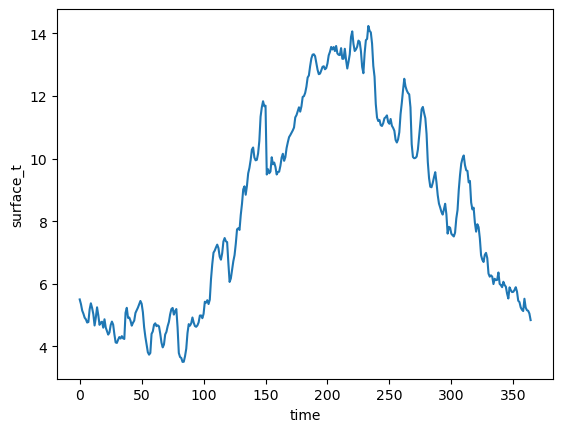

In [ ]:
# Test getting the mean directly when we pull the three nodes
# manually inserting them
test_mean = fvcom_1978.surface_t.isel(node = [26971,27320,27319]).mean(dim = ["node"])
test_mean.plot()

In [ ]:
# If we went through the rows we could pass the correct indices in for the triangle
# That way we'd have one vector instead of 3

# Set what lookup table and the xr.dataset 
df = inshore_nodes
ds  = fvcom_1978
data_var = "surface_t"
# Assume 'time' is the time dimension and 'data_var' is the variable of interest

# Store the timeseries and weights in dictionaries for lookup
elem_timeseries_data = {}
time_series_weights = {}

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    triangle_id = row['elem']
    elem_weight = row["rel_area"]
    # p1, p2, p3 = row['p1'], row['p2'], row['p3']
    
    
    # # Extract the time series for p1, p2, p3
    # ts_p1 = ds[data_var].isel(node = p1)
    # ts_p2 = ds[data_var].isel(node = p2)
    # ts_p3 = ds[data_var].isel(node = p3)
    
    # # Calculate the average time series
    # average_ts = (ts_p1 + ts_p2 + ts_p3) / 3

    # or do it this way
    nodes = [row['p1'], row["p2"], row["p3"]] 
    
    # Subtract 1 from each value in the list b/c python
    nodes = [x - 1 for x in nodes]
    
    # Get the average
    average_ts = ds[data_var].isel(node = nodes).mean(dim = ["node"])

    # Store the result in a dictionary or any other structure
    elem_timeseries_data[triangle_id] = average_ts
    time_series_weights[triangle_id] = elem_weight

# # If you want to convert it to a DataFrame, you can do so like this:
# result_df = pd.DataFrame(time_series_data)

In [ ]:
# Each timeseries is now stored by element name in a dictionary
# And same with the weights
#elem_timeseries_data.keys()

TypeError: 'dict_keys' object is not subscriptable

In [ ]:
df.head()

,SHORT_NAME,Id_1,FULL_NAME,elem,p1,p2,p3,rel_area
0,Eastern Maine,511,EASTERN MAINE,53546,26971,27320,27319,1.565751e+02
1,Eastern Maine,511,EASTERN MAINE,53559,26978,27326,27325,1.352508e+06
2,Eastern Maine,511,EASTERN MAINE,53560,27326,26978,26979,1.430821e+05
3,Eastern Maine,511,EASTERN MAINE,53561,27327,27326,26979,7.174698e+05
4,Eastern Maine,511,EASTERN MAINE,54232,27681,27680,27318,2.283860e+02


## WORKING Here

I decided to try and keep the full workflow in R to be more helpful to others, but everything works through here. All we need to do is loop through the regions in the table, pull out the relevant triangles and the relative areas, and do the weighted averages. 

In python we could do this all with one big fvcom object loaded with open_mfdataset(), so maybe I will revisit that.

In [ ]:
# From here, we could groupby/loop through each region and do the weighted averages of the triangles at play: